In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('/content/Mall_Customers.csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


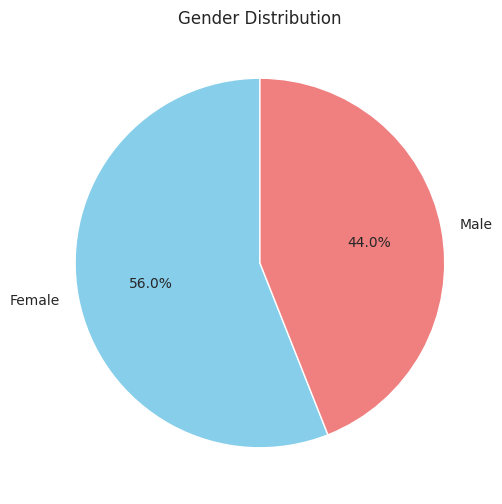

In [4]:
import matplotlib.pyplot as plt

# Get value counts
gender_counts = df['Gender'].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',      # show percentage with 1 decimal
    startangle=90,          # rotate start
    colors=['skyblue', 'lightcoral']
)

plt.title('Gender Distribution')
plt.show()


/tmp/ipython-input-215480682.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Age', data=df, palette='hsv')


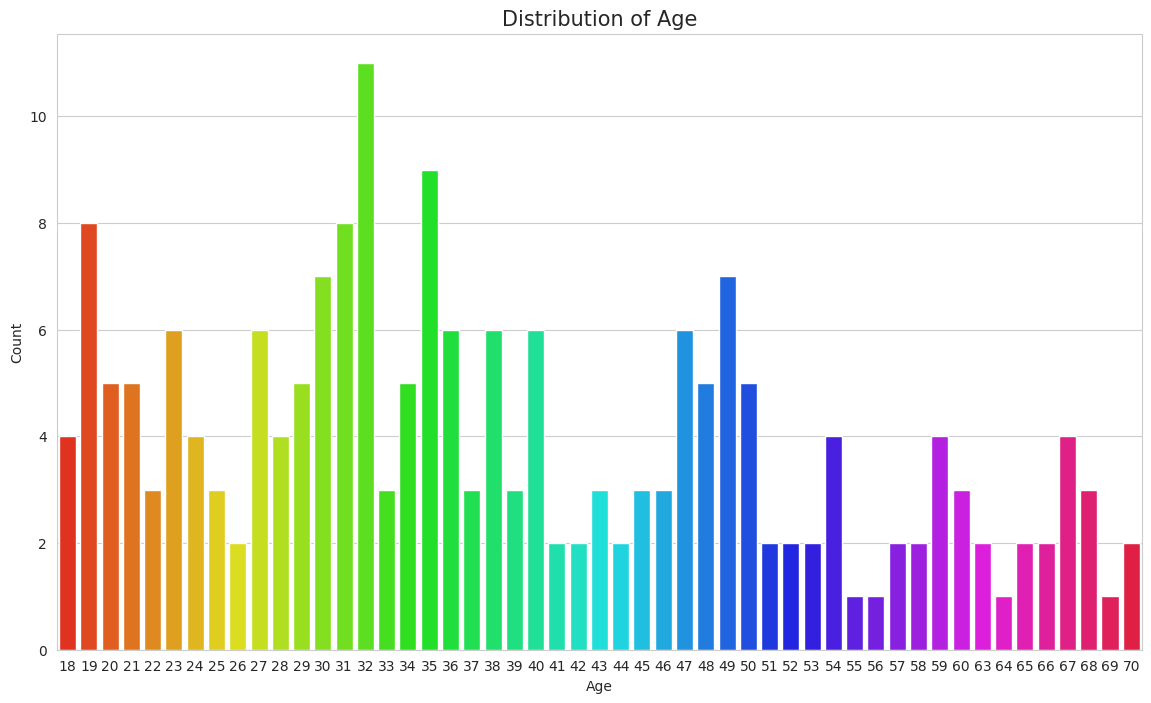

In [5]:
plt.figure(figsize=(14,8))
sns.countplot(x='Age', data=df, palette='hsv')
plt.title('Distribution of Age', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

By looking at the above graph-, It can be seen that the Ages from 27 to 39 are very much frequent but there is no clear pattern, we can only find some group wise patterns such as the the older age groups are lesser frequent in comparison. Interesting Fact, There are equal no. of Visitors in the Mall for the Agee 18 and 67. People of Age 55, 56, 69, 64 are very less frequent in the Malls. People at Age 32 are the Most Frequent Visitors in the Mall.

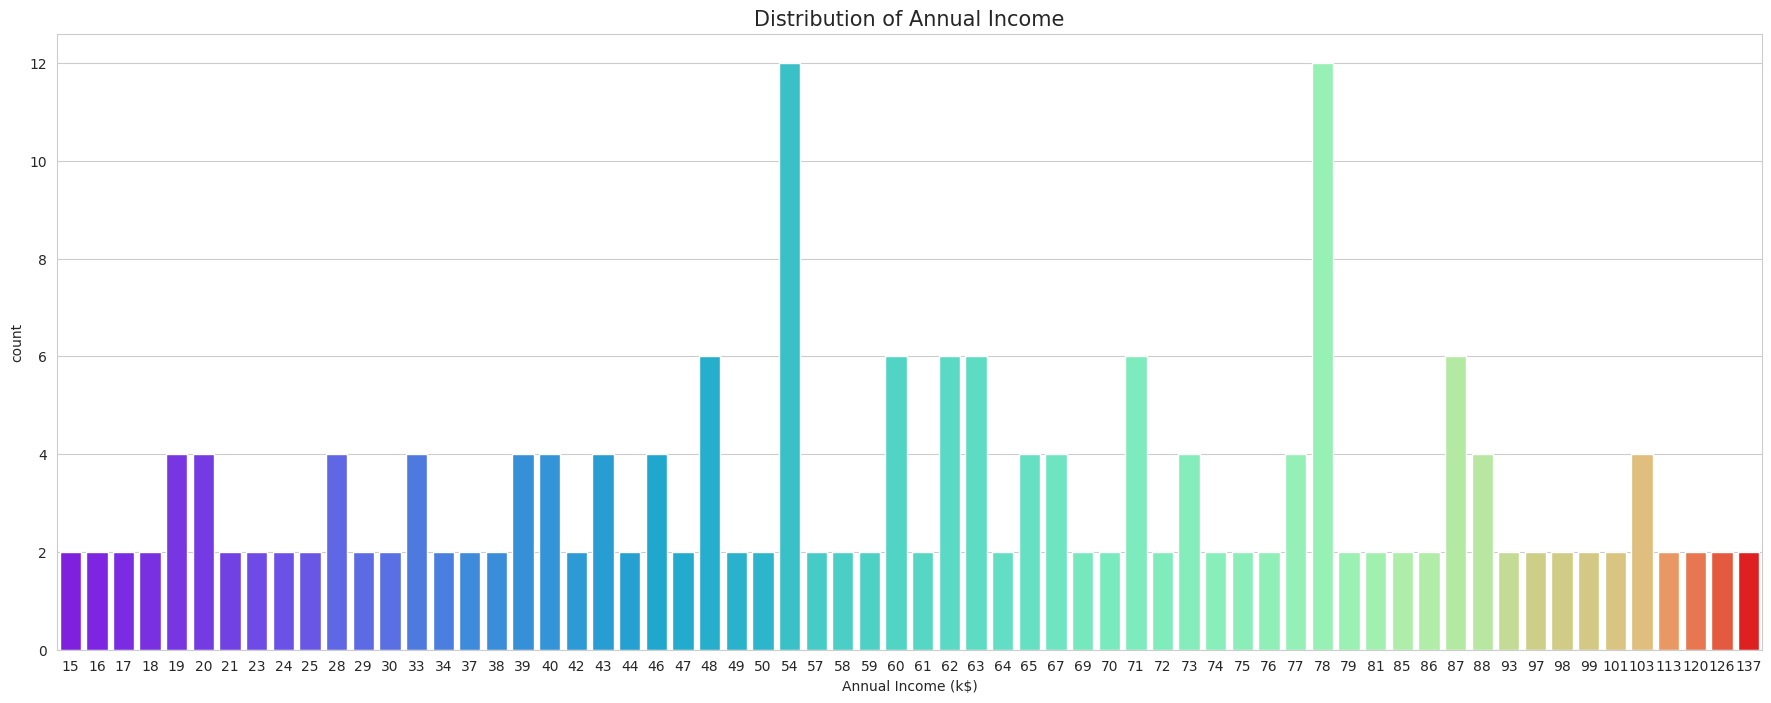

In [6]:
plt.figure(figsize=(22,8))
sns.countplot(
    x='Annual Income (k$)',
    data=df,
    hue='Annual Income (k$)',   # set hue same as x
    palette='rainbow',
    legend=False                # hide redundant legend
)
plt.title('Distribution of Annual Income', fontsize=15)
plt.show()

Again, This is also a chart to better explain the Distribution of Each Income level, Interesting there are customers in the mall with a very much comparable freqyuency with their Annual Income ranging from 15 US Dollars to 137K US Dollars. There are more Customers in the Mall whoc have their Annual Income as 54k US Dollars or 78 US Dollars.

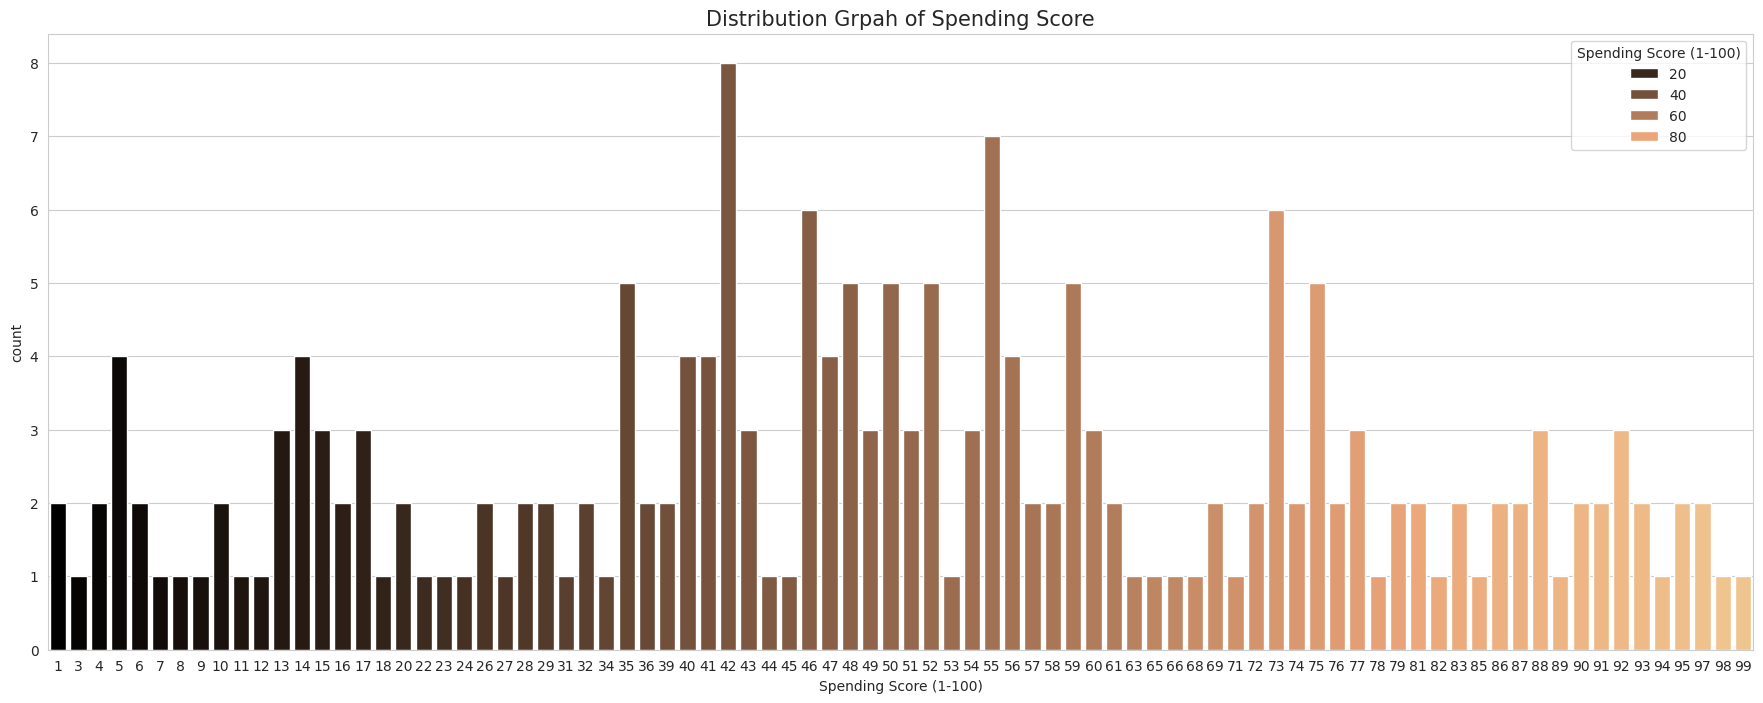

In [7]:
plt.figure(figsize=(22,8))
sns.countplot(x='Spending Score (1-100)',data=df,hue="Spending Score (1-100)", palette = 'copper')
plt.title('Distribution Grpah of Spending Score', fontsize = 15)
plt.show()

On a general level, we may conclude that most of the Customers have their Spending Score in the range of 35-60. Interesting there are customers having I spending score also, and 99 Spending score also, Which shows that the mall caters to the variety of Customers with Varying needs and requirements available in the Mall.

In [8]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Droping the CustomerID as it's just an identifier and not useful for clustering
df = df.drop('CustomerID', axis=1, errors='ignore')
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df = df.rename(columns={'Gender_Male': 'Is_Male'})

print("\nDescriptive Statistics:")

print("---------------------")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
---------------------
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000            

In [9]:
df.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Is_Male'], dtype='object')

**Feature Engineering**

**Income-to-Age ratio** → higher ratio might mean wealthier young customers

In [10]:
df['Income_Age_Ratio'] = df['Annual Income (k$)'] / df['Age']

**Normalized Spending** → spending relative to income

In [11]:
df['Spending_per_Income'] = df['Spending Score (1-100)'] / df['Annual Income (k$)']


**Univariate Analysis Feature Distributtion**

Text(0.5, 1.0, 'Correlation Factors Heat Map')

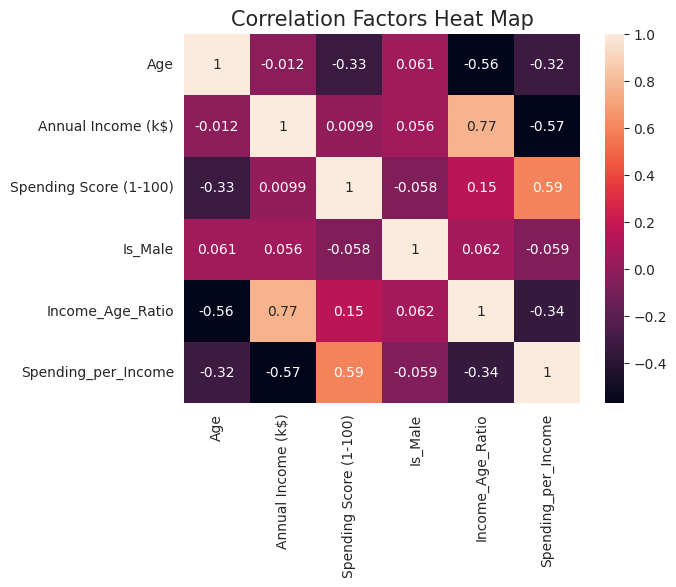

In [12]:
## Correlation coeffecients heatmap
sns.heatmap(df.corr(), annot=True).set_title('Correlation Factors Heat Map', size='15')

📊 Key Observations

Strong Positive Correlation

Annual Income (k$) and Income_Age_Ratio → 0.77
→ People with higher income tend to have a higher income-to-age ratio.

Spending Score (1-100) and Spending_per_Income → 0.59
→ Higher spending scores generally correspond to a larger portion of income spent.

Moderate Positive Correlation

Is_Male and Cluster_Label → 0.52
→ Gender seems to influence cluster assignment moderately.

Strong Negative Correlation

Age and Income_Age_Ratio → -0.56
→ Younger customers have higher income-to-age ratios.

Annual Income (k$) and Spending_per_Income → -0.57
→ Higher income individuals spend a smaller fraction of income.

Weak Correlations

Many other pairs (like Age with Annual Income (k$) or Is_Male) have correlations near zero, meaning minimal linear relationship.

💡 Interpretation for Clustering

The strong correlation between Annual Income and Income_Age_Ratio means one of them might be redundant for clustering.

The moderate correlation between Spending Score and Spending_per_Income also suggests possible overlap.

So,we consider by removing or combining these highly correlated variables to avoid overweighting them in distance-based clustering (like K-Means).

In [13]:

# Select the columns you want to use for clustering (including engineered features)
clustering_features = [ 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Scale all relevant features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[clustering_features])

# Convert back to a DataFrame for analysis
df_scaled = pd.DataFrame(scaled_data, columns=clustering_features)


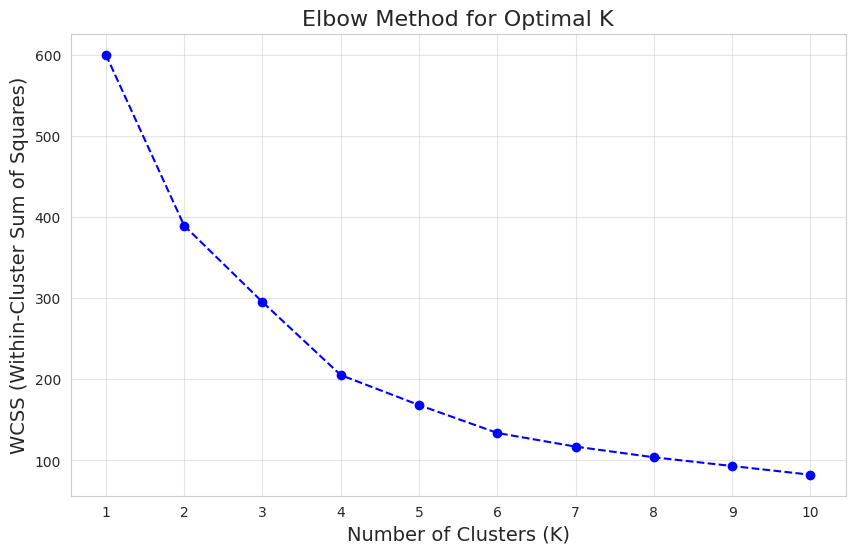

In [14]:

# --- Elbow Method ---
wcss = []
# Test K from 1 up to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# --- Plotting the Elbow Curve ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=14)
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.5)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster_Label'] = kmeans.fit_predict(scaled_data)

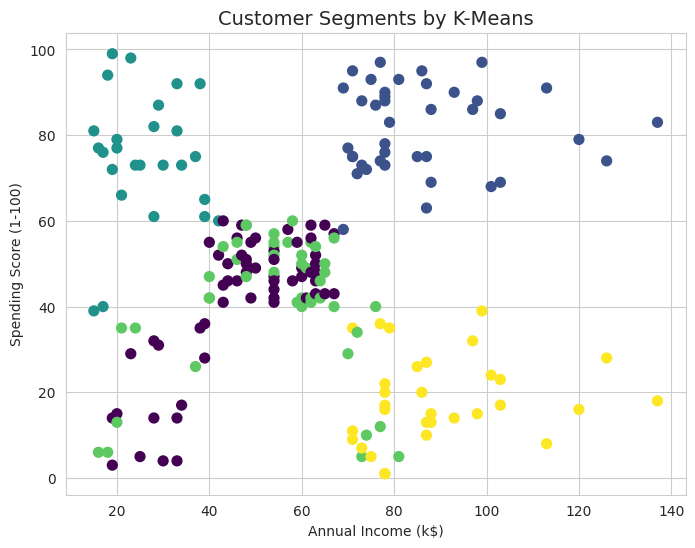

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
            c=df['Cluster_Label'], cmap='viridis', s=50)
plt.title('Customer Segments by K-Means', fontsize=14)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()


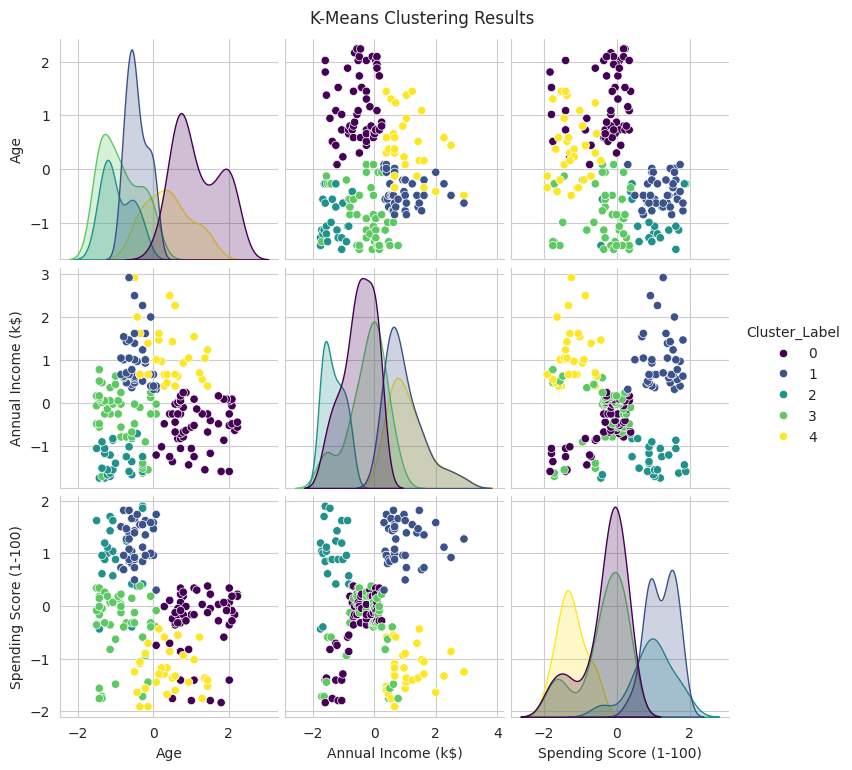

In [17]:
df_scaled['Cluster_Label'] = df['Cluster_Label'].values
sns.pairplot(df_scaled, vars=clustering_features, hue='Cluster_Label', palette='viridis')
plt.suptitle('K-Means Clustering Results', y=1.02)
plt.show()

| **Cluster**      | **Profile Summary**                          | **Behavioral Insights**                                                              | **Business Actions**                                                                                         |
| ---------------- | -------------------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| 🟣 **Cluster 0** | **High Income, Low Spending Score**          | Affluent customers who spend conservatively.                                         | Offer **premium loyalty programs**, **exclusive events**, or **investment products** to increase engagement. |
| 🟢 **Cluster 2** | **Low Income, High Spending Score**          | Young, aspirational spenders — likely enjoy lifestyle products despite lower income. | Target with **affordable luxury**, **discounts**, and **credit offers** to maintain retention.               |
| 🟡 **Cluster 4** | **High Income, High Spending Score**         | Ideal customers — high purchasing power and high engagement.                         | **Retain** and **reward** with VIP perks, personalized services, and early access offers.                    |
| 🔵 **Cluster 1** | **Moderate Income, Moderate Spending Score** | Middle-tier customers; balanced spenders.                                            | Upsell via **bundled offers**, cross-selling mid-range products.                                             |
| 🟣 **Cluster 3** | **Low Income, Low Spending Score**           | Price-sensitive and disengaged customers.                                            | Use **basic plans**, **mass promotions**, or **seasonal discounts** to re-engage.                            |


📊 Key Business Insights

High-value segment (Cluster 4) – represents customers who are both wealthy and active spenders → retain at all costs.

Potential growth segment (Cluster 2) – low-income but high-spending customers are brand-engaged; may convert to long-term loyal customers.

Efficiency opportunity (Cluster 0) – high-income, low spenders indicate untapped potential. You can focus marketing here.

Budget segment (Cluster 3) – not profitable currently but could respond to price or bundle promotions.

Middle segment (Cluster 1) – stable, consistent base customers, useful for maintaining revenue balance.